<a href="https://colab.research.google.com/github/ethangearey/nc-lora/blob/main/Experiment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 3: LoRA and Frozen Backbone Probes
- Take a pretrained classifier (e.g., trained ResNet).
- Fine-tune only the final layer using LoRA, varying the rank (e.g., 1–16).
- Evaluate:
 - Whether NC geometry persists or evolves under low-rank adaptation.
 - If LoRA directions align with NC class mean directions (cosine similarity, projection overlap).

### TODO
1. baseline: full fine-tuning (necessary?) (think: MPU)
2. validate data collection


In [31]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import drive
import psutil
import os
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab Notebooks/experiment_data/' # save and retrieve data from here
os.makedirs(data_path, exist_ok=True)

# Reuse existing imports and configurations from Experiment 1+2
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
from torchvision import datasets, transforms
from IPython import embed
from sklearn.decomposition import IncrementalPCA
from peft import LoraConfig, get_peft_model

debug = True # Only runs 20 batches per epoch for debugging

# Random seed
seed                = 42
torch.manual_seed(seed)
np.random.seed(seed)

# CIFAR dataset parameters
im_size             = 32
padded_im_size      = 32
input_ch            = 3
C                   = 10

# Optimization Criterion
loss_name = 'CrossEntropyLoss'

lr                  = 0.01 # verify with ablation
batch_size          = 128
momentum            = 0.9
weight_decay        = 5e-4 # too high?

# analysis parameters
epochs              = 2
ranks               = [1,2,4,8,16]
lora_alpha          = 16
lora_dropout        = 0.05
RANK_THRESHOLDS     = [0.95, 0.99]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader, epoch):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    all_features = []
    class_features = [[] for _ in range(C)]

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Metrics']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)
            output = model(data)

            h = features.value.data.view(data.shape[0],-1) # B CHW

            # Collect all features for rank analysis
            if computation == 'Mean':
              all_features.append(h.detach())

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                # Collect class-specific features for SVD analysis
                if computation == 'Mean':
                    class_features[c].append(h_c.detach())

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Metrics':
                    ## COV
                    # update within-class cov
                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
                graphs.mean = mean
            loss /= sum(N)

            # Feature rank analysis
            all_features_tensor = torch.cat(all_features, dim=0)

            # Compute feature rank using *torch SVD*
            with torch.no_grad():
                _, S, _ = torch.linalg.svd(all_features_tensor, full_matrices=False)
                S = S[:100]  # Only keep top 100 components

            # Calculate effective rank
            normalized_sv = S / torch.sum(S)
            cumulative_energy = torch.cumsum(normalized_sv, dim=0)
            effective_ranks = {}
            for thresh in RANK_THRESHOLDS:
                effective_ranks[str(thresh)] = (torch.sum(cumulative_energy < thresh) + 1).item() # convert tensor to scalar
            graphs.feature_rank.append(effective_ranks)
            graphs.singular_values.append(S.cpu().numpy())

            # Class means SVD
            U_M, S_M, V_M = torch.svd(M, some=True)
            graphs.mean_singular_values.append(S_M.cpu().numpy())

            # Class-wise SVD analysis
            class_sv_lists = []
            for c in range(C):
                if len(class_features[c]) > 0:
                    class_feat = torch.cat(class_features[c], dim=0).to(device)
                    # Center the features
                    class_feat = class_feat - mean[c].unsqueeze(0)
                    # Compute SVD
                    try:
                        _, S_c, _ = torch.svd(class_feat, some=True)
                        class_sv_lists.append(S_c.cpu().numpy())
                    except:
                        # Handle potential numerical issues
                        class_sv_lists.append(np.zeros(min(class_feat.shape)))

            graphs.class_singular_values.append(class_sv_lists)
        elif computation == 'Metrics':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm, with LoRA weights
    if hasattr(model.fc, 'lora_A'):
        lora_A = model.fc.lora_A['default'].weight
        lora_B = model.fc.lora_B['default'].weight
        W_effective = model.fc.weight + (lora_B @ lora_A) # W_effective replaces W
    else:
        W_effective = model.fc.weight

    M_norms = torch.norm(M_, dim=0)
    W_norms = torch.norm(W_effective.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # tr{Sw Sb^-1}
    Sw = Sw.double()
    Sw += 1e-8 * torch.eye(Sw.shape[0], device=Sw.device) # add jitter for numerical sability
    Sb = Sb.double()  # Extra precision for small eigenvalues; modified orig.
    eigvec, eigval, _ = torch.linalg.svd(Sb, full_matrices=False)
    eigvec = eigvec[:, :C-1]
    eigval = eigval[:C-1]
    inv_Sb = eigvec @ torch.diag(1/eigval) @ eigvec.T
    graphs.Sw_invSb.append(torch.trace(Sw @ inv_Sb).item())

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W_effective.T / torch.norm(W_effective.T, 'fro')
    graphs.W_M_dist.append(torch.norm(normalized_W - normalized_M)**2) # .item()?

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W_effective.T/W_norms))



class Graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

    self.mean         = []
    self.feature_rank = [] # stores dict [{'0.95': rank1, '0.99': rank2}
    self.singular_values = []
    self.mean_singular_values = []
    self.class_singular_values = []


LoRA Rank 4 Epoch 1:   0%|          | 1/390 [37:03<240:17:39, 2223.80s/it, Loss=2.3]


In [33]:
def prepare_lora_model(pretrained_model, rank=4):
    config = LoraConfig(
        r=rank,
        lora_alpha=lora_alpha,
        target_modules=["fc"],  # Apply LoRA to final layer
        lora_dropout=lora_dropout,
        bias="none",
    )
    model = get_peft_model(pretrained_model, config)
    print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model.to(device)


def compute_alignment_metrics(model, class_means, rank):
    """Calculate alignment between LoRA directions and NC class means."""
    lora_A = model.base_model.model.fc.lora_A['default'].weight  # [rank, in_dim]
    lora_B = model.base_model.model.fc.lora_B['default'].weight  # [out_dim, rank]
    W_lora = lora_B @ lora_A  # Combined LoRA direction [out_dim, in_dim]

    # Project class means onto LoRA subspace
    M = class_means.T.cpu().numpy()  # [in_dim, C]
    U, _, _ = randomized_svd(W_lora.detach().cpu().numpy(), n_components=rank)

    # Cosine similarity between LoRA directions and current class means
    cos_sims = []
    for c in range(M.shape[1]):
        v = M[:, c]
        for i in range(U.shape[1]):
            u = U[:, i]
            cos_sim = np.dot(u, v) / (np.linalg.norm(u)*np.linalg.norm(v)+1e-8)
            cos_sims.append(cos_sim)

    # Subspace projection score
    proj = U.T @ M
    proj_score = np.linalg.norm(proj)**2 / np.linalg.norm(M)**2

    return np.mean(cos_sims), proj_score


In [34]:
def train_lora(model, criterion, device, train_loader, optimizer, epoch, rank):
    model.train()
    # model.fc.original.requires_grad_(False)  # redundant as peft freezes weights automatically

    pbar = tqdm(total=len(train_loader), desc=f'LoRA Rank {rank} Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Update progress bar
        pbar.set_postfix({'Loss': loss.item()})
        pbar.update(1)

        if debug and batch_idx > 20:
            break
    pbar.close()


In [35]:
# ====================== EXECUTION ======================
# checkpoint from Experiment 1+2
checkpoint = torch.load('/content/drive/MyDrive/checkpoint.pth', weights_only=False)

# dataset, optimizer setup from Experiment 1+2
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

criterion = nn.CrossEntropyLoss()
criterion_summed = nn.CrossEntropyLoss(reduction='sum')

## Run Experiment 3
original_class_means = None  # To store initial NC geometry
for rank in ranks:

    results = []

    # Load fresh pretrained model for each run
    pretrained_model = models.resnet18(pretrained=False, num_classes=C)
    pretrained_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    pretrained_model.maxpool = nn.Identity()
    # Register feature hook
    class features:
        pass
    def hook(self, input, output):
        features.value = input[0].clone()
    pretrained_model.fc.register_forward_hook(hook)
    pretrained_model.load_state_dict(checkpoint['model_state_dict'])
    pretrained_model.to(device)

    # Apply LoRA
    model = prepare_lora_model(pretrained_model, rank=rank)
    # optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
    optimizer = optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=momentum,
                          weight_decay=weight_decay) # SGD, not Adam, for consistency with Exp1+2

    # Initial NC state, from Exp1+2
    graphs = Graphs()
    analysis(graphs, model, criterion_summed, device, C, analysis_loader, epoch=0)
    original_class_means = torch.stack(graphs.mean).T if original_class_means is None else original_class_means

    # Experiment 3: Fine-tune pretrained model for 20 epochs under LoRA
    for epoch in range(1, epochs + 1):
        train_lora(model, criterion, device, train_loader, optimizer, epoch, rank)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader, epoch)

        # Compute alignment metrics
        current_class_means = torch.stack(graphs.mean).T
        cos_sim, proj_score = compute_alignment_metrics(model, current_class_means, rank)

        results.append({
            'rank': rank,
            'epoch': epoch,
            'Sw_invSb': graphs.Sw_invSb[-1],
            'W_M_dist': graphs.W_M_dist[-1],
            'NCC_mismatch': graphs.NCC_mismatch[-1],
            'norm_M_CoV': graphs.norm_M_CoV[-1],
            'norm_W_CoV': graphs.norm_W_CoV[-1],
            'cos_M': graphs.cos_M[-1],
            'cos_W': graphs.cos_W[-1],
            'feature_rank_95': [x['0.95'] for x in graphs.feature_rank],
            'feature_rank_99': [x['0.99'] for x in graphs.feature_rank],
            'cos_sim': cos_sim,
            'proj_score': proj_score
            # 'test_acc': graphs.accuracy[-1]  # Assuming test loader available
        })

    # Save results per rank
    pd.DataFrame(results).to_csv(data_path + f'lora_rank_{rank}_results.csv', index=False)

    # # Save singular values (optional)
    # for rank in ranks:
    #     np.save(data_path + f'rank_{rank}_feature_svs.npy', graphs.singular_values)
    #     np.save(data_path + f'rank_{rank}_mean_svs.npy', graphs.mean_singular_values)
    #     np.save(data_path + f'rank_{rank}_class_svs.npy', graphs.class_singular_values)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Trainable parameters: 522


Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [00:59<17:32,  2.85s/it]


Trainable parameters: 1044


Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [01:08<20:11,  3.28s/it]


Trainable parameters: 2088


Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [00:57<16:54,  2.75s/it]


Trainable parameters: 4176


Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [00:59<17:22,  2.83s/it]


Trainable parameters: 8352


Analysis Metrics	Epoch: 2 [21/390 (5%)]:   5%|▌         | 21/390 [00:59<17:18,  2.81s/it]


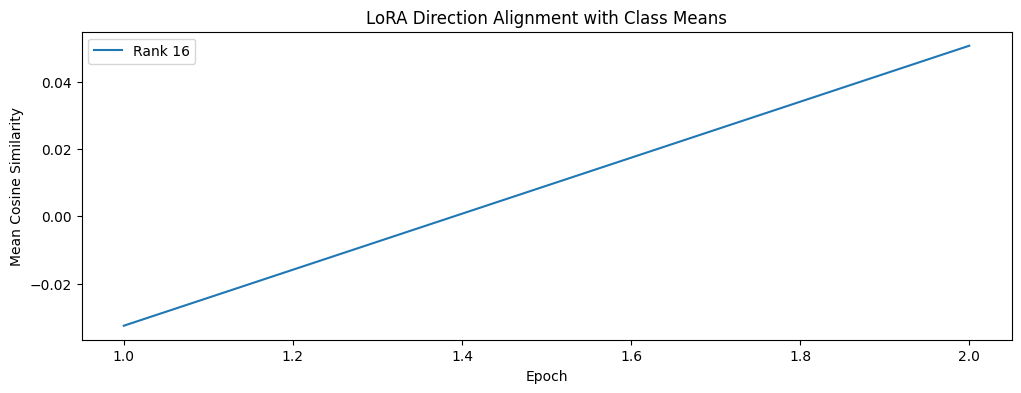

KeyError: 'NC1'

<Figure size 1200x400 with 0 Axes>

In [36]:
# Visualization
df = pd.DataFrame(results)
plt.figure(figsize=(12, 4))
for rank in df['rank'].unique():
    subset = df[df['rank'] == rank]
    plt.plot(subset['epoch'], subset['cos_sim'], label=f'Rank {rank}')
plt.xlabel('Epoch')
plt.ylabel('Mean Cosine Similarity')
plt.title('LoRA Direction Alignment with Class Means')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
for rank in df['rank'].unique():
    subset = df[df['rank'] == rank]
    plt.plot(subset['epoch'], subset['NC1'], label=f'Rank {rank}')
plt.xlabel('Epoch')
plt.ylabel('NC1 (Tr{Sw Sb^-1})')
plt.title('Neural Collapse Persistence During LoRA Tuning')
plt.legend()
plt.show()

## Experiment 3b: LoRA Before NC
Does the implementation of LoRA (restriction of parameter updates to low-rank) accelerate or disrupt NC behavior when implemented before collapse?

## Baseline: Full Fine-Tuning


From Sonnet; not debugged

In [ ]:
# After your LoRA experiments, add:

# Full fine-tuning baseline
full_model = models.resnet18(pretrained=False, num_classes=C)
full_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
full_model.maxpool = nn.Identity()
full_model.load_state_dict(checkpoint['model_state_dict'])
full_model.to(device)

# Register hook
full_model.fc.register_forward_hook(hook)

# Save original weights for later comparison
original_fc_weights = full_model.fc.weight.clone().detach()

# For full fine-tuning, only train the classifier layer for fair comparison with LoRA
for param in full_model.parameters():
    param.requires_grad = False
full_model.fc.weight.requires_grad = True
full_model.fc.bias.requires_grad = True

# Use same optimizer as LoRA experiments
optimizer = optim.SGD(full_model.fc.parameters(), lr=0.01, momentum=momentum, weight_decay=weight_decay)

# Train and collect same metrics
full_results = []
graphs = Graphs()
for epoch in range(1, 21):
    train_full_ft(full_model, criterion, device, train_loader, optimizer, epoch)
    analysis(graphs, full_model, criterion_summed, device, C, analysis_loader, epoch)

    # Compute weight update and its rank
    current_weights = full_model.fc.weight.clone().detach()
    weight_delta = current_weights - original_fc_weights
    weight_delta_rank = compute_effective_rank(weight_delta)

    # Current class means
    current_class_means = torch.stack(graphs.mean).T

    # Store results with same metrics as LoRA
    full_results.append({
        'method': 'full_ft',
        'epoch': epoch,
        'NC1': graphs.Sw_invSb[-1],
        'NC2': graphs.norm_M_CoV[-1],
        'NC3': graphs.W_M_dist[-1],
        'NC4': graphs.NCC_mismatch[-1],
        'weight_update_rank': weight_delta_rank,
        'class_mean_change': torch.norm(current_class_means - original_class_means).item(),
    })

pd.DataFrame(full_results).to_csv('full_ft_results.csv', index=False)